# Quick start tutorial ML Ops



**Introduction to MLRun - Use serverless functions to train and deploy models**

This notebook provides a quick overview of developing and deploying machine learning applications.

## Set-up

Let's initialize our working environment. Import required libraries:


In [1]:
import digitalhub as dh

Create a project:



In [2]:
PROJECT = "demo-ml"
project = dh.get_or_create_project(PROJECT)


<a id="generate-data"></a>
## Generate data


**Function code**

Run the following cell to generate the data prep file (or copy it manually):

In [3]:
%%writefile data-prep.py

import pandas as pd
from sklearn.datasets import load_breast_cancer

from digitalhub_runtime_python import handler

@handler(outputs=["dataset"])
def breast_cancer_generator():
    """
    A function which generates the breast cancer dataset
    """
    breast_cancer = load_breast_cancer()
    breast_cancer_dataset = pd.DataFrame(
        data=breast_cancer.data, columns=breast_cancer.feature_names
    )
    breast_cancer_labels = pd.DataFrame(data=breast_cancer.target, columns=["target"])
    breast_cancer_dataset = pd.concat(
        [breast_cancer_dataset, breast_cancer_labels], axis=1
    )

    return breast_cancer_dataset


Overwriting data-prep.py


Register it as a function:

In [4]:
data_gen_fn = project.new_function(
                         name="data-prep",
                         kind="python",
                         python_version="PYTHON3_9",
                         code_src="data-prep.py",
                         handler="breast_cancer_generator")


Run it locally:



In [5]:
gen_data_run = data_gen_fn.run(action="job", outputs={"dataset": "dataset"}, local_execution=True)

2024-07-16 11:42:39,029 - INFO - Validating task.
2024-07-16 11:42:39,030 - INFO - Validating run.
2024-07-16 11:42:39,030 - INFO - Starting task.
2024-07-16 11:42:39,031 - INFO - Configuring execution.
2024-07-16 11:42:39,441 - INFO - Composing function arguments.
2024-07-16 11:42:39,442 - INFO - Executing run.
2024-07-16 11:42:39,623 - INFO - Task completed, returning run status.


You can view the state of the execution with gen_data_run.status or its output with gen_data_run.outputs(). You can see a few records from the output artifact:



## Model Training

In the context of breast cancer classification using SVM, the model training process involves utilizing a portion of the dataset to train the model on the relationships between the input features and the target variable.

**Step 1**: Get the values of independent and dependent variables

In [7]:
df_cancer = gen_data_run.outputs()["dataset"].as_df()

X = df_cancer.drop(['target'],axis=1)
y = df_cancer['target']

**Step 2**: Splitting the Data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)

**Step 3**: Importing and Training the Model

In [9]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train)


SVC()

## Model Prediction

Once the model is trained, use it to make classifications on the testing set.


In [10]:
y_predict = svc_model.predict(X_test)

## Model Evaluation

Evaluate the model’s performance using appropriate measures, such as accuracy, precision and recall, to assess how well it classified the cancer as ‘malignant’ or ‘benign’ on the testing set.



<AxesSubplot: >

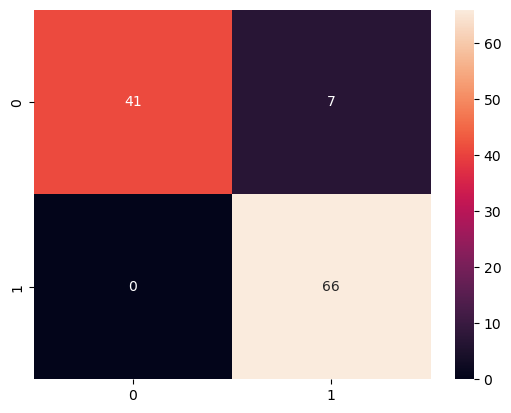

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)


In [12]:

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        48
           1       0.90      1.00      0.95        66

    accuracy                           0.94       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



## ML Ops

Let us define and execute the training function

In [24]:
%%writefile train-model.py

import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from digitalhub_runtime_python import handler
from sklearn.svm import SVC
from pickle import dump
import sklearn.metrics

@handler(outputs=["dataset"])
def train(project, di):

    df_cancer = di.as_df()
    X = df_cancer.drop(['target'],axis=1)
    y = df_cancer['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)
    svc_model = SVC()
    svc_model.fit(X_train, y_train)
    y_predict = svc_model.predict(X_test)

    with open("cancer_classifier.pkl", "wb") as f:
        dump(svc_model, f, protocol=5)

    metrics = {
        "f1_score": sklearn.metrics.f1_score(y_test, y_predict),
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_predict),
        "precision": sklearn.metrics.precision_score(y_test, y_predict),
        "recall": sklearn.metrics.recall_score(y_test, y_predict),
    }
    project.log_model(
            name="cancer_classifier",
            kind="model",
            source_path="cancer_classifier.pkl",
            algorithm="SVC",
            framework="sckit-learn",
            metrics=metrics
    )

Overwriting train-model.py


In [33]:
train_fn = project.new_function(
                         name="train",
                         kind="python",
                         python_version="PYTHON3_9",
                         code_src="train-model.py",
                         handler="train",
                         requirements=["scikit-learn==1.2.2"])


In [34]:
train_run = train_fn.run(action="job", inputs={"di": gen_data_run.outputs()["dataset"].key}, local_execution=False)

## Model Deployment and Testing

We define a serving module with two functions: for model initialization and model inference.

In [88]:
%%writefile "serve_model.py"

from pickle import load
import pandas as pd
import json

def init(context):
    # Qua ti setti il nome del modello che vuoi caricare
    model_name = "cancer_classifier"

    # prendi l'entity model sulla base del nome
    model = context.project.get_model(model_name)
    path = model.download()
    with open(path, "rb") as f:
        svc_model = load(f)

    # settare model nel context di nuclio (non su project che è il context nostro)
    setattr(context, "model", svc_model)

def serve(context, event):

    # Sostanzialmente invochiamo la funzione con una chiamata REST
    # Nel body della richiesta mandi l'inference input

    if isinstance(event.body, bytes):
        body = json.loads(event.body)
    else:
        body = event.body
    context.logger.info(f"Received event: {body}")
    inference_input = body["inference_input"]

    data = json.loads(inference_input)
    pdf = pd.json_normalize(data)

    result = context.model.predict(pdf)

    # Convert the result to a pandas DataFrame, reset the index, and convert to a list
    jsonstr = str(result.tolist())
    return json.loads(jsonstr)

Overwriting serve_model.py


In [89]:
func = project.new_function(name="serve_model",
                            kind="python",
                            python_version="PYTHON3_9",
                            base_image = "python:3.9",
                            code_src="serve_model.py",
                            handler="serve",
                            init_function="init",
                            requirements=["scikit-learn==1.2.2"])

In [90]:
serve_run = func.run(action="serve")

In [93]:
import requests
SERVICE_URL = serve_run.refresh().status.to_dict()["service"]["url"]
with requests.post(f'http://{SERVICE_URL}', json={"inference_input":X_test.to_json(orient='records')}) as r:
    res = r.json()
print(res)

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
